# 🛒 Customer Segmentation using RFM Analysis  

**Objective:**  
Perform RFM (Recency, Frequency, Monetary) analysis on customer transaction data to segment customers into meaningful groups.  
This includes data cleaning, feature engineering, RFM scoring, customer segmentation, and visualizations. The goal is to uncover customer behavior patterns and suggest actionable marketing strategies.  

**R (Recency):** How recently a customer made a purchase.

**F (Frequency):** How often they made purchases.

**M (Monetary):** How much money they spent.

**Dataset Source:**  
[Online Retail Dataset – UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/352/online+retail)  
- Transactions from a UK-based online retail store between **Dec 2010 – Dec 2011**.  
- ~500,000 rows, 8 features (`InvoiceNo`, `StockCode`, `Description`, `Quantity`, `InvoiceDate`, `UnitPrice`, `CustomerID`, `Country`).  

**Libraries Used:**  
- **Pandas** → data cleaning & feature engineering  
- **NumPy** → numerical calculations  
- **Matplotlib** → visualizations (bar charts, line plots)  
- **Seaborn** → advanced visualizations (heatmaps, distribution plots)  


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings for cleaner tables
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_colwidth', 120)

sns.set(style="whitegrid", context="talk")

## Load Dataset

In [2]:
DATA_PATH = "Online Retail.xlsx"  

usecols = ["InvoiceNo","StockCode","Description","Quantity","InvoiceDate","UnitPrice","CustomerID","Country"]
df = pd.read_excel(DATA_PATH, usecols=usecols, parse_dates=["InvoiceDate"])

In [3]:
print("Raw shape:", df.shape)
df.head()

Raw shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom


## Data Understanding 

In [4]:
print("\nColumns:", list(df.columns))
print("\nDate range:", df["InvoiceDate"].min(), "→", df["InvoiceDate"].max()) 
print("\nUnique countries:", df["Country"].nunique())
print("\nMissing values (ratio):")
display(df.isna().mean().sort_values(ascending=False).to_frame("missing_ratio"))

print("\nBasic stats (Quantity & UnitPrice):")
display(df[["Quantity","UnitPrice"]].describe(percentiles=[.01,.05,.5,.95,.99]))


Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Date range: 2010-12-01 08:26:00 → 2011-12-09 12:50:00

Unique countries: 38

Missing values (ratio):


,missing_ratio
CustomerID,0.25
Description,0.00
StockCode,0.00
InvoiceNo,0.00
Quantity,0.00
InvoiceDate,0.00
UnitPrice,0.00
Country,0.00



Basic stats (Quantity & UnitPrice):


,Quantity,UnitPrice
count,"541,909.00","541,909.00"
mean,9.55,4.61
std,218.08,96.76
min,"-80,995.00","-11,062.06"
1%,-2.00,0.19
5%,1.00,0.42
50%,3.00,2.08
95%,29.00,9.95
99%,100.00,18.00
max,"80,995.00","38,970.00"


## Data Cleaning

In [5]:
df = df.dropna(subset=['CustomerID'])

In [6]:
df["CustomerID"] = df["CustomerID"].astype(int)

In [7]:
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")] # Remove order cancellations

In [8]:
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

### Cleaning Steps:
1. **Remove missing Customer IDs** → Customers without IDs cannot be tracked.  
2. **Remove cancelled orders** → Invoices starting with "C" are cancellations.  
3. **Keep only positive quantities & prices** → Negative values represent returns, and zero/negative prices are invalid.  
4. **Convert InvoiceDate to datetime** → Required for calculating Recency.

## After Cleaning

In [11]:
print("Cleaned shape:", df.shape)
df.head()

Cleaned shape: (397884, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


**Cleaned Dataset Shape:** (397,884 rows × 9 columns)  

In [ ]:
# 5) RFM calculations
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby("CustomerID")
      .agg(
          Recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
          Frequency=("InvoiceNo", "nunique"),
          Monetary=("TotalPrice", "sum")
      )
      .reset_index()
)

print("RFM shape:", rfm.shape)
display(rfm.describe())
rfm.head(10)


In [ ]:
# 6) RFM scoring (quantiles 1-5)
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1])   # recent => higher score
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5])

# Composite fields
rfm["RFM_Score"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm["RFM_Score_Num"] = rfm[["R_Score","F_Score","M_Score"]].astype(int).sum(axis=1)

rfm.head()


In [ ]:
# 7) Segmentation
def label_segment(row):
    r = int(row["R_Score"])
    f = int(row["F_Score"])
    m = int(row["M_Score"])

    if r >= 4 and f >= 4 and m >= 4:
        return "Champions"
    if f >= 4 and m >= 3:
        return "Loyal"
    if m >= 4 and f <= 3:
        return "Big Spenders"
    if r <= 2 and (f >= 3 or m >= 3):
        return "At Risk"
    if r <= 2 and f <= 2 and m <= 2:
        return "Hibernating"
    return "Others"

rfm["Segment"] = rfm.apply(label_segment, axis=1)

seg_counts = rfm["Segment"].value_counts().rename_axis("Segment").to_frame("Count")
seg_counts["Share"] = seg_counts["Count"]/seg_counts["Count"].sum()
display(seg_counts)


## RFM Analysis  

RFM stands for **Recency, Frequency, and Monetary Value**.  
It is a popular technique in marketing and customer analytics to segment customers based on their purchasing behavior.  

- **Recency (R):** How recently a customer made a purchase.  
- **Frequency (F):** How often a customer makes a purchase.  
- **Monetary (M):** How much money a customer spends.  

We calculate these values for each customer.  

In [12]:
reference_date = df["InvoiceDate"].max()
print("Reference Date:", reference_date)

Reference Date: 2011-12-09 12:50:00


 **A reference date (the latest date in the dataset).**

### Calculate RFM metrics

In [13]:
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                                   # Frequency
    "TotalPrice": "sum"                                       # Monetary
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,"77,183.60"
1,12347,1,7,"4,310.00"
2,12348,74,4,"1,797.24"
3,12349,18,1,"1,757.55"
4,12350,309,1,334.40


In [14]:
rfm.tail(10)

,CustomerID,Recency,Frequency,Monetary
4328,18273,1,3,204.00
4329,18274,29,1,175.92
4330,18276,43,1,335.86
4331,18277,57,1,110.38
4332,18278,73,1,173.90
4333,18280,277,1,180.60
4334,18281,180,1,80.82
4335,18282,7,2,178.05
4336,18283,3,16,"2,094.88"
4337,18287,42,3,"1,837.28"


In [15]:
print(f"Transactions: {df.shape[0]}, Customers: {df['CustomerID'].nunique()}")


Transactions: 397884, Customers: 4338


## Dataset Size  

Now we have transformed the raw transaction data into an **RFM table**.  

- **Transactions(397884):** Each row represents a product purchased (invoice line).  
- **Customers(4338):** Unique `CustomerID`s in the dataset.
- Each row = **one customer**  
- Columns = Recency, Frequency, Monetary values  

## 🎯 RFM Scoring & Segmentation  

Once we calculate Recency, Frequency, and Monetary (RFM), we assign **scores** to each customer.  
This helps us group customers into segments such as **loyal customers, big spenders, or at-risk customers**.

- **Recency Score (R):** Lower recency = higher score (recent buyers).  
- **Frequency Score (F):** More purchases = higher score.  
- **Monetary Score (M):** Higher spending = higher score.  


In [17]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])

rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# Combine RFM scores into one string
rfm['RFM_Segment'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

# Calculate overall RFM score (average)
rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].astype(int).mean(axis=1)

rfm.head(10)

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Segment,RFM_Score
0,12346,325,1,"77,183.60",1,1,5,115,2.33
1,12347,1,7,"4,310.00",5,5,5,555,5.00
2,12348,74,4,"1,797.24",2,4,4,244,3.33
3,12349,18,1,"1,757.55",4,1,4,414,3.00
4,12350,309,1,334.40,1,1,2,112,1.33
5,12352,35,8,"2,506.04",3,5,5,355,4.33
6,12353,203,1,89.00,1,1,1,111,1.00
7,12354,231,1,"1,079.40",1,1,4,114,2.00
8,12355,213,1,459.40,1,1,2,112,1.33
9,12356,22,3,"2,811.43",4,3,5,435,4.00


- Recency: lower is better, so we reverse the scoring
- Frequency & Monetary: higher is better

## Customer Segmentation

In [18]:
def segment_me(score):
    if score >= 4.5:
        return "Champions"
    elif score >= 4:
        return "Loyal Customers"
    elif score >= 3:
        return "Potential Loyalist"
    elif score >= 2:
        return "Needs Attention"
    else:
        return "At Risk"

rfm['Segment'] = rfm['RFM_Score'].apply(segment_me)

rfm['Segment'].value_counts()


Segment
Needs Attention       1178
Potential Loyalist    1022
At Risk                883
Champions              647
Loyal Customers        608
Name: count, dtype: int64

### 📊 RFM Analysis Visualizations 

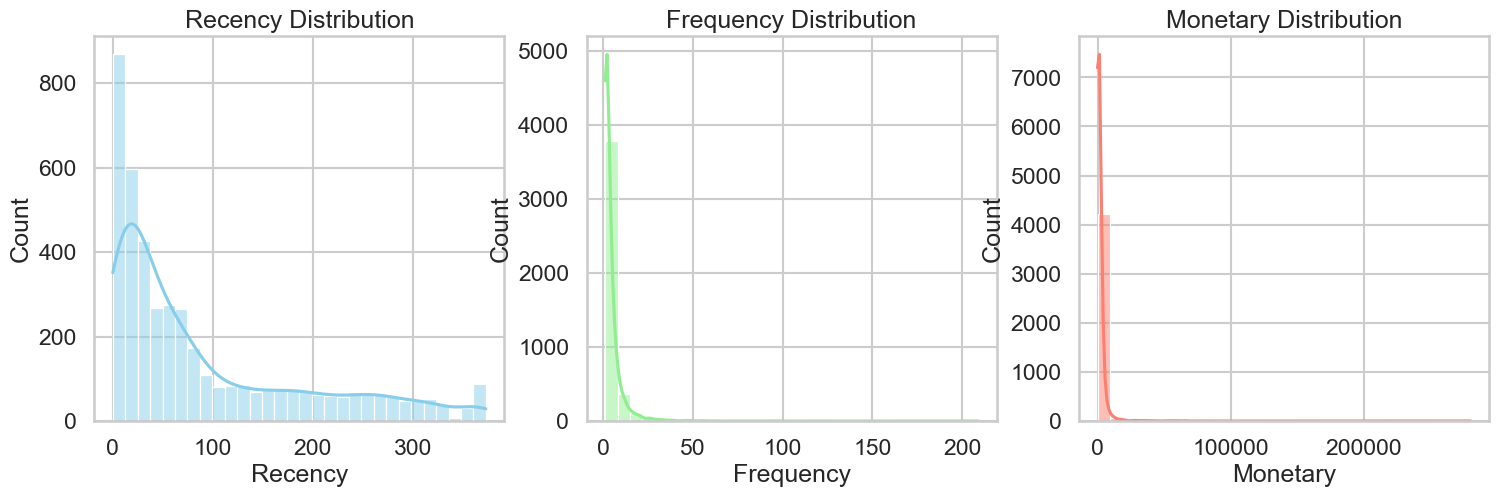

In [22]:
fig, axes = plt.subplots(1,3, figsize=(18,5))
sns.histplot(rfm['Recency'], bins=30, ax=axes[0], kde=True, color="skyblue")
axes[0].set_title("Recency Distribution")

sns.histplot(rfm['Frequency'], bins=30, ax=axes[1], kde=True, color="lightgreen")
axes[1].set_title("Frequency Distribution")

sns.histplot(rfm['Monetary'], bins=30, ax=axes[2], kde=True, color="salmon")
axes[2].set_title("Monetary Distribution")

plt.show()


 The histograms below show how customer purchase behavior is spread:  
- **Recency**: How recently customers made their last purchase.  
- **Frequency**: How often customers purchase.  
- **Monetary**: How much money customers spend.  

These plots help detect skewness (e.g., most customers buy rarely, but a few buy very frequently).


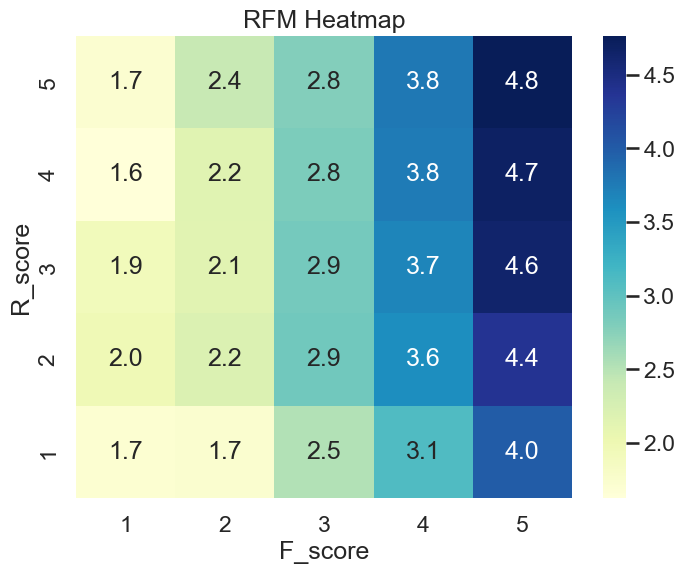

In [30]:
rfm['M_score'] = pd.to_numeric(rfm['M_score'], errors='coerce')

rfm_pivot = rfm.pivot_table(
    index='R_score',
    columns='F_score',
    values='M_score',
    aggfunc='mean',
    observed=False
)

plt.figure(figsize=(8,6))
sns.heatmap(rfm_pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("RFM Heatmap")
plt.show()



The heatmap below combines Recency (R), Frequency (F), and Monetary (M) scores.  
- Darker cells indicate higher average `M_score`.  
- It helps to quickly see which R–F combinations bring the highest monetary value.  
- For example, customers with **low Recency (recent buyers) and high Frequency** usually bring the most revenue.


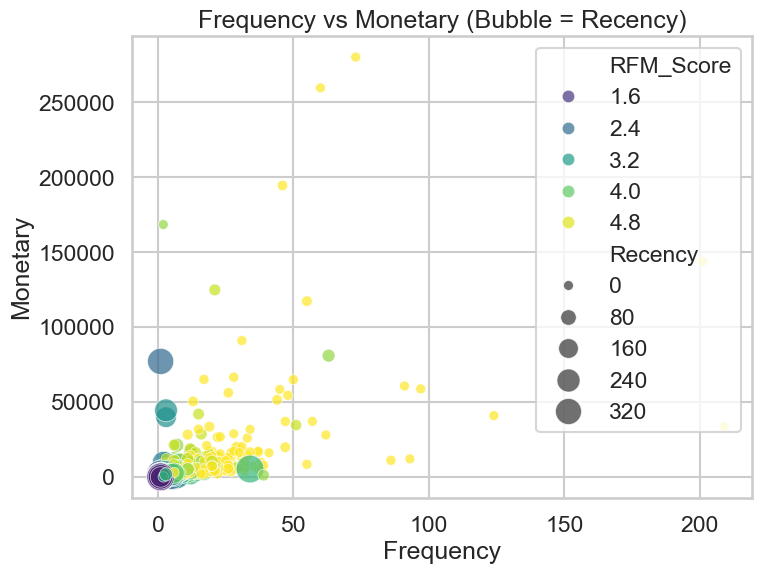

In [26]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', size='Recency', hue='RFM_Score', palette="viridis", alpha=0.7, sizes=(50,400))
plt.title("Frequency vs Monetary (Bubble = Recency)")
plt.show()


 
This scatter plot shows:  
- **X-axis**: Purchase Frequency  
- **Y-axis**: Monetary Value  
- **Bubble size**: Recency (smaller = more recent)  
- **Bubble color**: RFM Score  

It highlights clusters like **high spenders with recent activity** vs **old customers with low spending**.


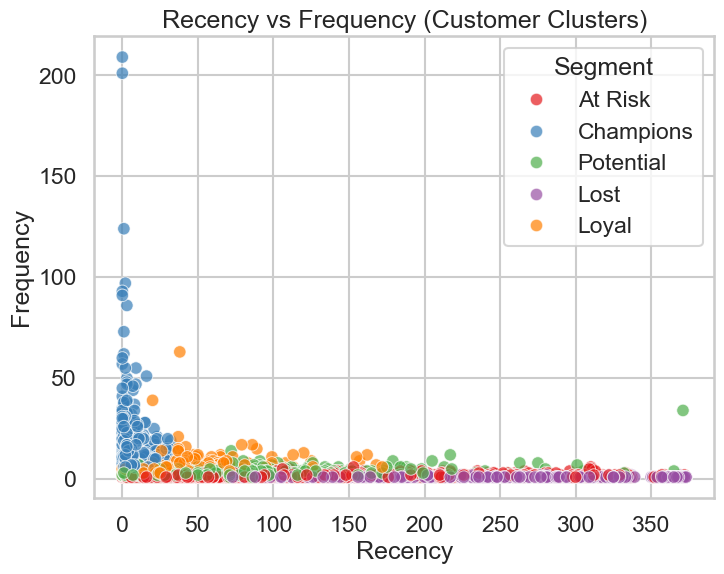

In [27]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Segment', palette="Set1", alpha=0.7)
plt.title("Recency vs Frequency (Customer Clusters)")
plt.show()


 This scatter plot groups customers by Recency and Frequency with color-coded segments.  
- Top-right = frequent + recent buyers → most loyal customers  
- Bottom-left = inactive + rare buyers → customers at risk of churn  
This visualization is useful for identifying **target groups for marketing campaigns**.


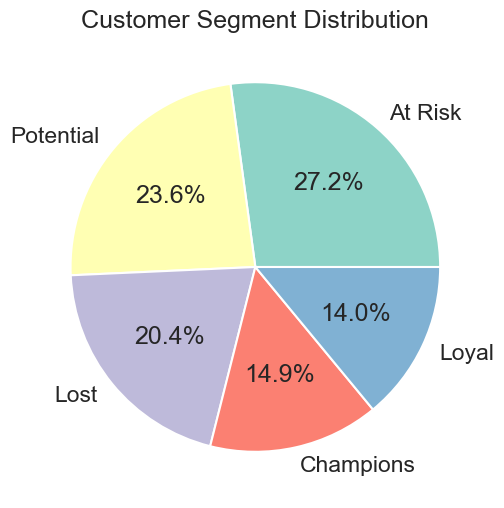

In [28]:
rfm['Segment'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(6,6), colors=sns.color_palette("Set3"))
plt.title("Customer Segment Distribution")
plt.ylabel("")
plt.show()


#### Customer Segment Distribution 
This chart shows the proportion of customers in each RFM segment.  
It provides a quick overview of the **relative size of loyal, potential, and at-risk customer groups**.


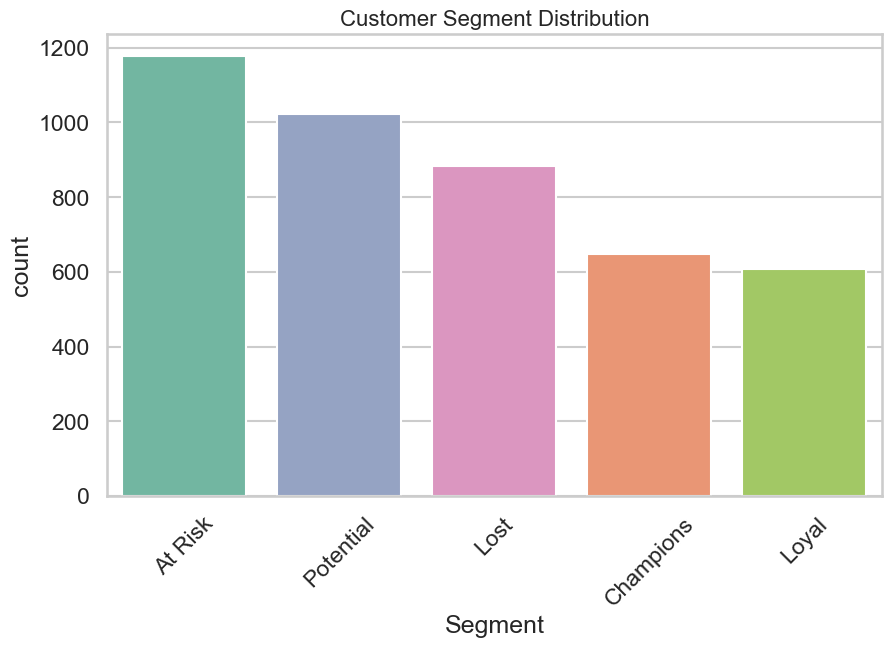

In [38]:
# --- 3. Countplot of Segments ---
plt.figure(figsize=(10,6))
sns.countplot(
    data=rfm,
    x='Segment',
    order=rfm['Segment'].value_counts().index,
    hue='Segment',          # ✅ explicit
    palette="Set2",
    legend=False
)
plt.title("Customer Segment Distribution", fontsize=16)
plt.xticks(rotation=45)
plt.show()

The bar chart displays the **exact counts of customers** in each segment.  
Unlike the pie chart, it’s better for comparing segment sizes side by side.  
This helps decide **where to focus retention or acquisition efforts**.


## 📌 Final Insights from RFM Analysis  

Based on the RFM analysis and visualizations:  

1. **Customer Distribution**  
   - A large portion of customers fall into **low-frequency and low-monetary segments**, meaning most customers purchase infrequently and spend less.  
   - Only a smaller group of customers are **high-value and loyal**.  

2. **Key Patterns**  
   - Customers who purchase **more frequently and more recently** tend to have the **highest monetary contribution**.  
   - Inactive or “at risk” customers (high Recency, low Frequency) form a significant segment → need re-engagement strategies.  

3. **Business Implication**  
   - Focusing marketing efforts on the **top segments (Champions & Potential Loyalists)** will yield the most impact.  
   - Retention strategies for **At Risk** customers can prevent churn and save future acquisition costs.  

✅ **Conclusion**: RFM analysis reveals that a small percentage of customers drive the majority of revenue. By segmenting and targeting customers based on Recency, Frequency, and Monetary value, businesses can **prioritize resources more effectively** and design **personalized marketing strategies**.
